This notebook is only created for the purpose of training a modified Neural Network with more number of epochs
Float64 is changed to Float32

Results:

3000 Epochs
Basic small NN model


In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\MIT\Courses\6338-Parallel_computing_and_scientific_machine_learning\project\project_work_sciml\project_work_sciml`


In [2]:
using BenchmarkTools
using Flux
using StaticArrays
using Parameters: @with_kw
using Zygote
using Plots
using GLMakie
using Makie
using ProgressMeter
using ForwardDiff
using ZygoteRules
using Flux: throttle
using BSON: @save

ZygoteRules.@adjoint function ForwardDiff.Dual{T}(x, ẋ::Tuple) where T
  @assert length(ẋ) == 1
  ForwardDiff.Dual{T}(x, ẋ), ḋ -> (ḋ.partials[1], (ḋ.value,))
end
ZygoteRules.@adjoint ZygoteRules.literal_getproperty(d::ForwardDiff.Dual{T}, ::Val{:partials}) where T =
  d.partials, ṗ -> (ForwardDiff.Dual{T}(ṗ[1], 0),)
ZygoteRules.@adjoint ZygoteRules.literal_getproperty(d::ForwardDiff.Dual{T}, ::Val{:value}) where T =
  d.value, ẋ -> (ForwardDiff.Dual{T}(0, ẋ),)
  Zygote.refresh()

In [3]:
#Parameter values:

const λ = 1f0 #1
const μ = 5f-1 #0.5
const Q = 4f0 #4

4.0f0

In [4]:
#Body forces:

@inline fxf(x,y) = λ*(4f0π^2f0*cos(2f0π*x)*sin(π*y)-π*cos(π*x)*Q*y^3)+μ*(9f0π^2f0*cos(2f0π*x)*sin(π*y)-π*cos(π*x)*Q*y^3)
@inline fyf(x,y) = λ*(-3f0*sin(π*x)*Q*y^2f0+2f0π^2f0*sin(2f0π*x)*cos(π*y))+μ*(-6f0*sin(π*x)*Q*y^2f0+2f0π^2f0*sin(2f0π*x)*cos(π*x)+π^2f0*sin(π*x)*Q*y^4f0/4f0)

#Corresponding displacement functions
@inline uxf(x,y)=cos(2f0π*x)*sin(π*y)
@inline uyf(x,y)=sin(π*x)*Q*y^4/4

#Dependent material properties
m_mat = @SMatrix [(λ+2f0*μ) λ 0; λ (λ+2f0*μ) 0; 0 0 2f0*μ] 
const E = μ*(3f0*λ+2f0*μ)/(λ+μ) #young's modulus
const ν = λ/2f0/(λ+μ) #poisson's ratio


0.33333334f0

In [5]:
#Data generation by sampling the 1x1 domain
num_p = 625 #need to be (n::Int)²
nxny = Int(sqrt(num_p))
#Empty initialized vectors for storing the true solution data
loc_xy=Vector{typeof(@SVector [1f0,1f0] )}(undef,num_p)
ut = Vector{typeof(@SVector [1f0,1f0] )}(undef,num_p)
ft = Vector{typeof(@SVector [1f0,1f0] )}(undef,num_p)

σt = Vector{typeof(@SVector [1f0,1f0,1f0] )}(undef,num_p) 
uxydxy_temp = Array{Float32}(undef,2,2)
ξ_temp = Vector{Float32}(undef,3)
uxydxyf(x,y) = vcat(transpose(collect(Zygote.gradient(uxf,x,y))),transpose(collect(Zygote.gradient(uyf,x,y))))
for (ic,i) in enumerate(0:oftype(1f0,1/(nxny-1)):1)
    for (jc,j) in enumerate(0:oftype(1f0,1/(nxny-1)):1)
        loc_xy[(ic-1)*nxny+jc] = @SVector [i,j]
        ut[(ic-1)*nxny+jc] = [uxf(i,j),uyf(i,j)]
        ft[(ic-1)*nxny+jc] = [fxf(i,j),fyf(i,j)]
        uxydxy_temp=uxydxyf(i,j)
        ξ_temp = [uxydxy_temp[1,1],uxydxy_temp[2,2],(uxydxy_temp[2,1]+uxydxy_temp[1,2])/2]
        σt[(ic-1)*nxny+jc] = m_mat*ξ_temp
    end 
end

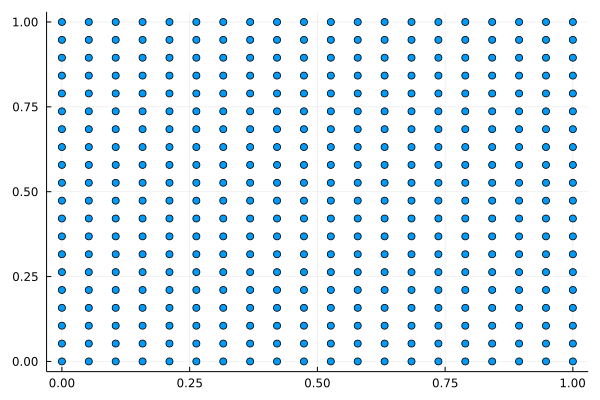

In [45]:
Plots.scatter([loc_xy[i][1] for i in 1:length(loc_xy)],[loc_xy[i][2] for i in 1:length(loc_xy)],legend=false)

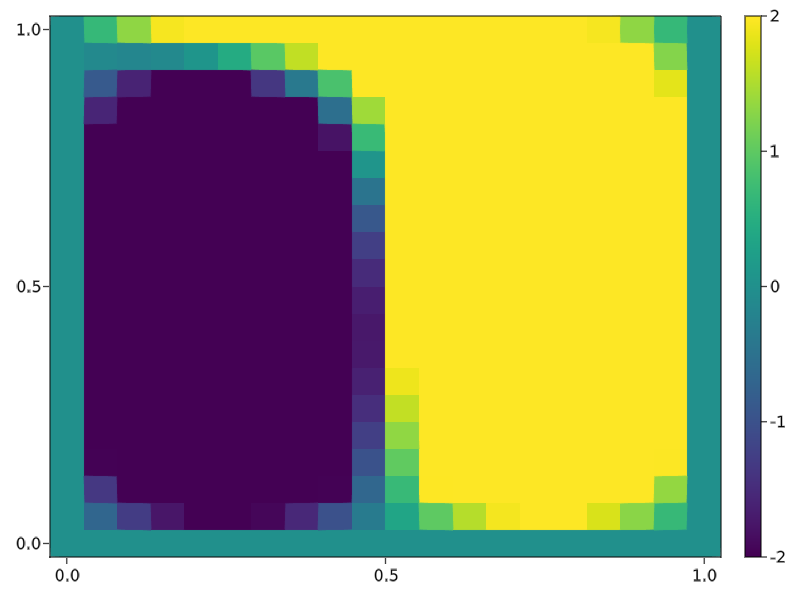

In [46]:
#plot check of the true stress, strains and displacements

joint_limits = (-2, 2)
fig, ax1, hm1 = Makie.heatmap(0:1/(nxny-1):1,0:1/(nxny-1):1,[σt[(i-1)*nxny+j][1] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)
#ax2, hm2 = Makie.heatmap(fig[1, end+1], 0:1/(nxny-1):1, 0:1/(nxny-1):1, [σt[(i-1)*nxny+j][2] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)
#ax3, hm3 = Makie.heatmap(fig[1, end+1], 0:1/(nxny-1):1, 0:1/(nxny-1):1, [σt[(i-1)*nxny+j][3] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)
#heatmap(loc_xy[i][1],[loc_xy[i][2] for i in 1:length(loc_xy)],[σt[i][2] for i in 1:length(σt)])
#[ for i in 1:nxny, for j in 1:nxny]


Colorbar(fig[:, end+1], colorrange = joint_limits)  # equivalent

fig

In [6]:
#Creating the neural network


function build_model(;inp_sz=2,out_sz=5)
    return Chain(
        Dense(inp_sz,15),
        BatchNorm(15,relu),
        Dense(15,20),
        BatchNorm(20,relu),
        Dense(20,15),
        BatchNorm(15,relu),
        Dense(15,5),
        BatchNorm(5)
    )
end
m = build_model()
D(x) = [x[2]*(x[2]-1f0), x[1]*(x[1]-1f0), x[1]*(x[1]-1f0), x[2]-1f0,1f0]
bv(x)=[0f0,0f0,0f0,(λ+2f0*μ)*Q*sin(π*x[1]),0f0]
mhb(x) = m(x).*D(x).+bv(x)

#mgrad_temp = Array{Float64}(undef,5,2)
#dξ_temp = Vector{Float64}(undef,10) 
model_grad(x) = ForwardDiff.jacobian(m,x)
function PINN_loss!( model,ft,m_mat,x,yt)
    #x - vector of input values at which the loss evaluation is required
    #yt- vector of true values corresponding to the input values x 
    #model - NN model
    y = model(x)
    #uσ_loss = mean(abs.(y-yt),dims=2)
    comp_loss = Flux.Losses.mae(y,yt,agg=mean)
    #mgrad_temp = Zygote.Buffer(x,5,2)
    mgrad_temp = ForwardDiff.jacobian(model,x)
    strain = [mgrad_temp[1,1],mgrad_temp[2,2],(mgrad_temp[1,2]+mgrad_temp[2,1])/2f0]
    phy_loss = abs(mgrad_temp[3,1]+mgrad_temp[5,2]+fxf(x[1],x[2])) + abs(mgrad_temp[4,2]+mgrad_temp[5,1]+fxf(x[1],x[2])) + sum(abs.(y[3:5]-m_mat*strain))
    return comp_loss +phy_loss
end

PINN_loss! (generic function with 1 method)

In [7]:
#Training parameters
batchsize = 300   # batch size
epochs = 1500       # number of epochs
opt = ADAMW(1e-4)  # η - learning rate

#preparing the data
#X_train = loc_xy[i]' for i in 1:length(loc_xy)]
X_train = reduce(vcat,transpose.(loc_xy))'
Y_train = reduce(vcat,transpose.([vcat(ut[i],σt[i]) for i in 1:num_p]))'
data = Flux.Data.DataLoader((X_train, Y_train), batchsize=40,shuffle=true);
#building the model

uσ_loss_stor = Vector{typeof(@SVector [0f0,0f0,0f0,0f0,0f0])}(undef,epochs)
fill!(uσ_loss_stor,@SVector [0f0,0f0,0f0,0f0,0f0])
uσc=1
loss(x,yt) = PINN_loss!(mhb,ft,m_mat,x,yt)


loss (generic function with 1 method)

In [8]:
loss_store = Vector{Float32}(undef,epochs)

evalcb = throttle(30) do 
  @save "loss_history.bson" loss_store
  @save "model.bson" m
end; 
function my_custom_train!(loss, ps, data, opt, loss_store, epc,evalcb)
  uσc=epc
  dl=length(data)
  for (ic,d) in enumerate(data)
    train_loss, back = Zygote.pullback(() -> loss(d...), ps)
    gs = back(one(train_loss))
    #evalcb()
    Flux.update!(opt, ps, gs)
    loss_store[epc]=train_loss
  end
end

my_custom_train! (generic function with 1 method)

In [9]:
ps = Flux.params(m)
@showprogress for i in 1:epochs
    #Flux.train!(loss, ps, data, opt)
    my_custom_train!(loss, ps, data, opt, loss_store, i,evalcb )
end
#println(mean(m(real)),mean(m(fake))) # Print model prediction

Progress: 100%|█████████████████████████████████████████| Time: 1:01:40m


In [51]:
@save "lh_bignet_400samp_firstmodel.bson" loss_store
@save "m_bignet_400samp_firstmodel.bson" m

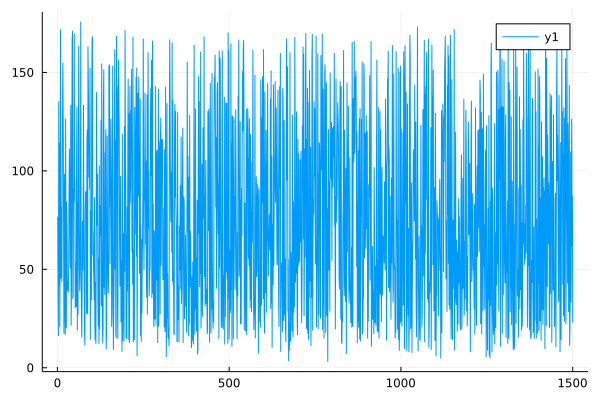

In [10]:
Plots.plot(loss_store)

In [11]:
σp = Vector{typeof(@SVector [1f0,1f0,1f0])}(undef,length(loc_xy))
σp2 = Vector{typeof(@SVector [1f0,1f0,1f0])}(undef,length(loc_xy))
σt2 = Vector{typeof(@SVector [1f0,1f0,1f0])}(undef,length(loc_xy))

function data_sampler!(ff, comp, loc_xy)
    for (i,loc) in enumerate(loc_xy)
        ff[i]=m(cat(loc,dims=2))[comp]
    end
end
function data_sampler(comp, loc_xy)
    #comp - the components at which sampling is required - ex: 1 or 2 or 2:4
    #loc_xy - A vector of vectors of the co-ordinate point locations.
    out_vec = Vector{typeof(Float32.(ones(length(comp))))}(undef,length(loc_xy))
    data_sampler!(out_vec, comp, loc_xy)
    return out_vec
end

data_sampler!(σp, 3:5,loc_xy)

In [31]:
[σp[(i-1)*nxny+j][1] for i in 1:nxny, j in 1:nxny]

20×20 Matrix{Float32}:
 0.0         -0.00189741   …  -0.0322559  -0.0341533  -0.0360508
 0.00132068  -0.00231228      -0.0352175  -0.0371149  -0.0390123
 0.00264136   0.000219515     -0.0380802  -0.0400503  -0.0419739
 0.00396203   0.00285545      -0.0403752  -0.0423451  -0.0443152
 0.00528271   0.00549137      -0.04267    -0.0446401  -0.0466101
 0.00660339   0.00812731   …  -0.0438132  -0.0460657  -0.0483183
 0.00792407   0.010597        -0.044917   -0.0471696  -0.0494222
 0.00924474   0.0119176       -0.046021   -0.0482735  -0.050526
 0.0105654    0.0132383       -0.0471248  -0.0493774  -0.0516299
 0.0118861    0.014559        -0.0482287  -0.0504813  -0.0527338
 0.0132068    0.0158796    …  -0.0493326  -0.0515851  -0.0538377
 0.0145275    0.0172003       -0.0504363  -0.052689   -0.0549415
 0.0158481    0.018521        -0.0507006  -0.0537929  -0.0560455
 0.0171688    0.0198416       -0.0488859  -0.0531493  -0.0571493
 0.0184895    0.0211623       -0.046578   -0.0513134  -0.0555979
 0.

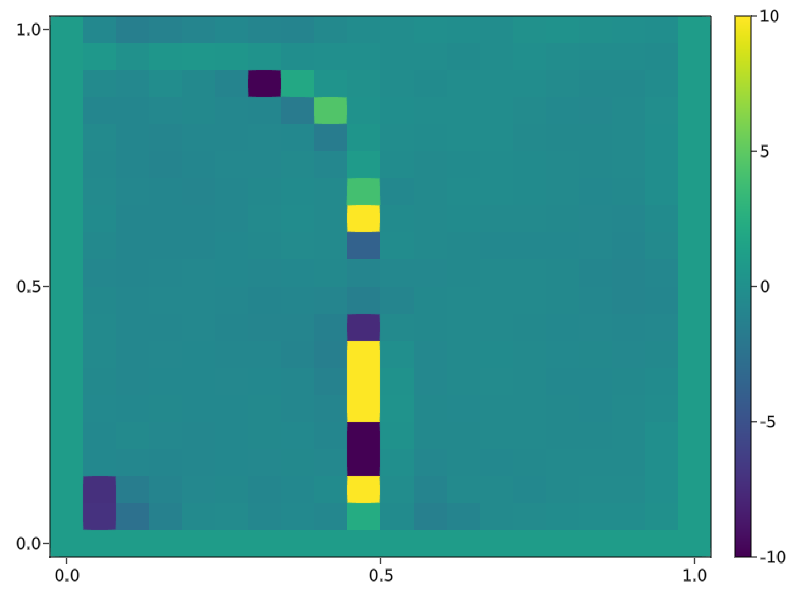

In [61]:
#plot check of the true stress, strains and displacements

joint_limits = (-10, 10)
fig1, ax1, hm1 = Makie.heatmap(0:1/(nxny-1):1,0:1/(nxny-1):1,[(σp[(i-1)*nxny+j][1]-σt[(i-1)*nxny+j][1])/σp[(i-1)*nxny+j][1] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)

#heatmap(loc_xy[i][1],[loc_xy[i][2] for i in 1:length(loc_xy)],[σt[i][2] for i in 1:length(σt)])
#[ for i in 1:nxny, for j in 1:nxny]


Colorbar(fig1[:, end+1], colorrange = joint_limits)  # equivalent

fig1

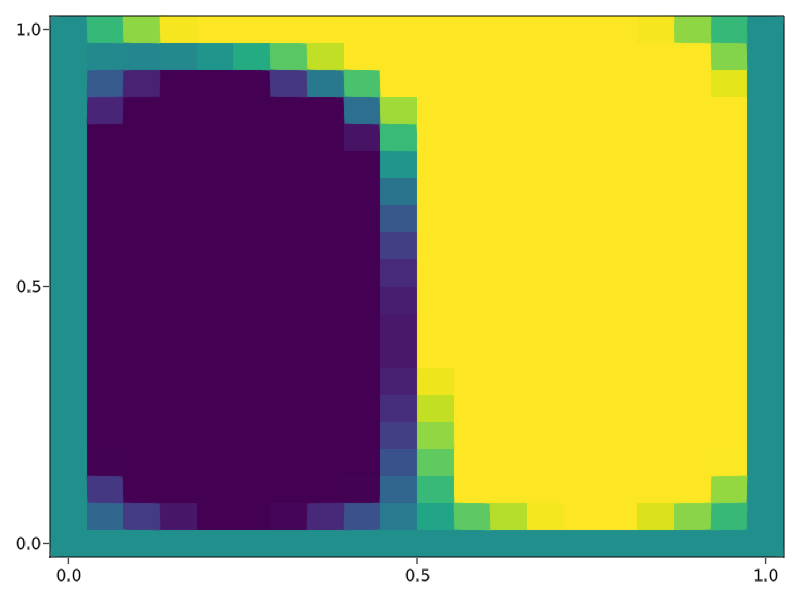

In [58]:
joint_limits = (-2, 2)
fig, ax1, hm1 = Makie.heatmap(0:1/(nxny-1):1,0:1/(nxny-1):1,[σt[(i-1)*nxny+j][1] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)

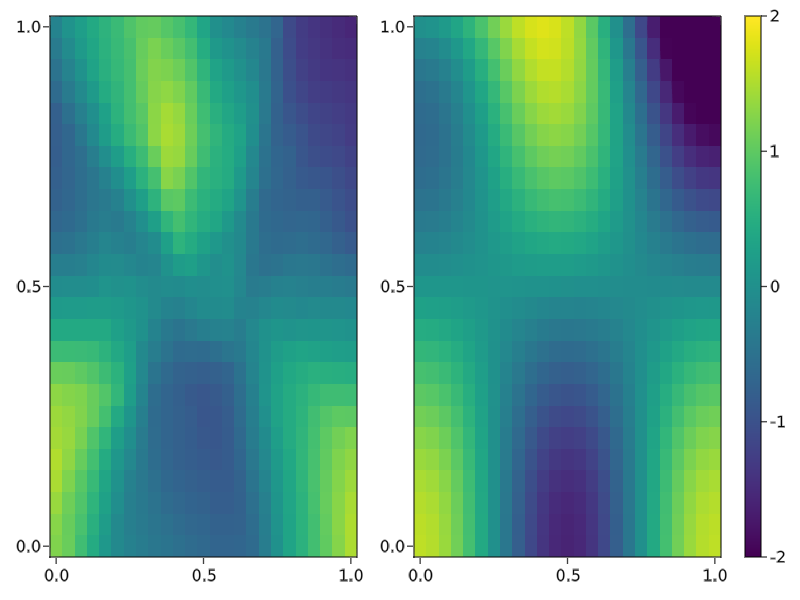

In [12]:
#plot check of the true stress, strains and displacements

joint_limits = (-2, 2)
fig, ax1, hm1 = Makie.heatmap(0:1/(nxny-1):1,0:1/(nxny-1):1,[σp[(i-1)*nxny+j][3] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)
ax2, hm2 = Makie.heatmap(fig[1, end+1], 0:1/(nxny-1):1, 0:1/(nxny-1):1, [σt[(i-1)*nxny+j][3] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)

#heatmap(loc_xy[i][1],[loc_xy[i][2] for i in 1:length(loc_xy)],[σt[i][2] for i in 1:length(σt)])
#[ for i in 1:nxny, for j in 1:nxny]


Colorbar(fig[:, end+1], colorrange = joint_limits)  # equivalent

fig

In [85]:
#Plots.plot(loss_store)
#Plots.plot(phy_loss)
for i in 1:num_p
    if uσ_loss_stor[i] != [0f0,0f0,0f0,0f0,0f0]
        @show i
    end
end
any(uσ_loss_stor[i] != [0f0,0f0,0f0,0f0,0f0])

false

In [54]:
function field_val_samp(num_p)
    #Data generation by sampling the 1x1 domain
    nxny = Int(sqrt(num_p))
    #Empty initialized vectors for storing the true solution data
    loc_xy=Vector{typeof(@SVector [1.0,1.0] )}(undef,num_p)
    ut = Vector{typeof(@SVector [1.0,1.0] )}(undef,num_p)
    ft = Vector{typeof(@SVector [1.0,1.0] )}(undef,num_p)
    σt = Vector{typeof(@SVector [1.0,1.0,1.0] )}(undef,num_p) 
    uxydxy_temp = Array{Float64}(undef,2,2)
    ξ_temp = Vector{Float64}(undef,3)
    uxydxyf(x,y) = vcat(transpose(collect(Zygote.gradient(uxf,x,y))),transpose(collect(Zygote.gradient(uyf,x,y))))
    for (ic,i) in enumerate(0:1/(nxny-1):1)
        for (jc,j) in enumerate(0:1/(nxny-1):1)
            loc_xy[(ic-1)*nxny+jc] = @SVector [i,j]
            ut[(ic-1)*nxny+jc] = [uxf(i,j),uyf(i,j)]
            ft[(ic-1)*nxny+jc] = [fxf(i,j),fyf(i,j)]
            uxydxy_temp=uxydxyf(i,j)
            ξ_temp = [uxydxy_temp[1,1],uxydxy_temp[2,2],(uxydxy_temp[2,1]+uxydxy_temp[1,2])/2]
            σt[(ic-1)*nxny+jc] = m_mat*ξ_temp
        end 
    end
    return loc_xy, ut, ft, σt 
end

num_p2 = 900 #need to be (n::Int)²
loc_xy2, ut2, ft2, σt2 =field_val_samp(num_p2);

In [58]:

σp2 = data_sampler(3:5, loc_xy2);

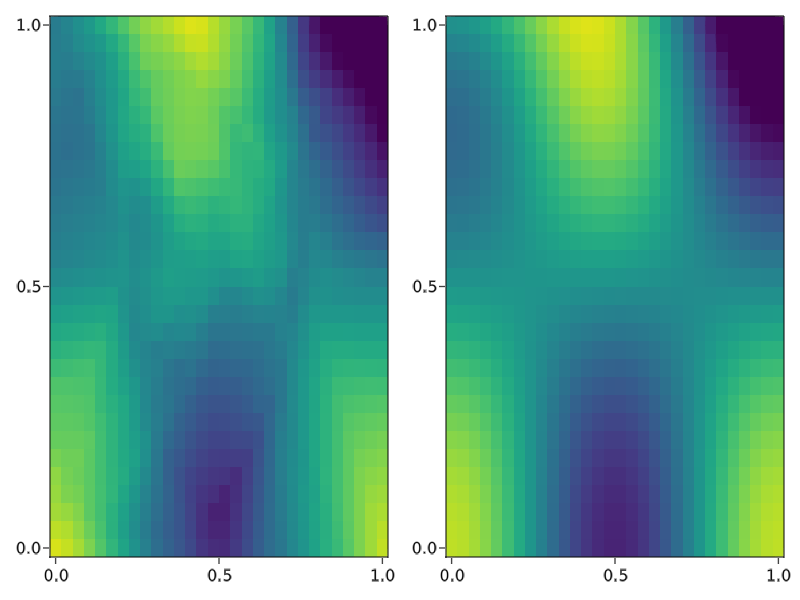

In [56]:
#plot check of the true stress, strains and displacements

joint_limits = (-2, 2)
fig2, ax1, hm1 = Makie.heatmap(0:1/(nxny2-1):1,0:1/(nxny2-1):1,[σp2[(i-1)*nxny2+j][3] for i in 1:nxny2, j in 1:nxny2], colorrange = joint_limits)
ax2, hm2 = Makie.heatmap(fig2[1, end+1], 0:1/(nxny2-1):1, 0:1/(nxny2-1):1, [σt2[(i-1)*nxny2+j][3] for i in 1:nxny2, j in 1:nxny2], colorrange = joint_limits)

#heatmap(loc_xy[i][1],[loc_xy[i][2] for i in 1:length(loc_xy)],[σt[i][2] for i in 1:length(σt)])
#[ for i in 1:nxny, for j in 1:nxny]


Colorbar(fig[:, end+1], colorrange = joint_limits)  # equivalent
fig2

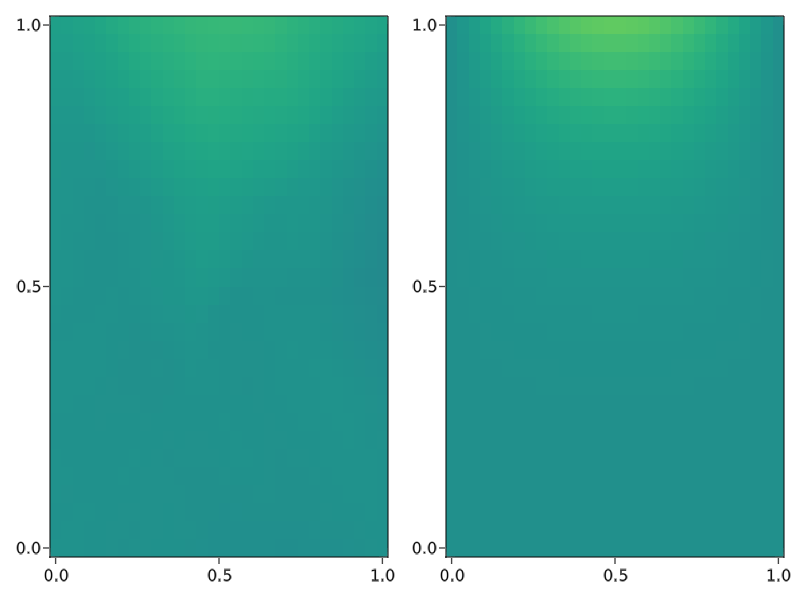

In [62]:
function plot_field_comp(lrf,trf,comp,nxny)
    #left plot - Learned distribution, right plot - Actual distribution
    joint_limits = (-2, 2)
    fig2, ax1, hm1 = Makie.heatmap(0:1/(nxny-1):1,0:1/(nxny-1):1,[lrf[(i-1)*nxny+j][comp] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)
    ax2, hm2 = Makie.heatmap(fig2[1, end+1], 0:1/(nxny-1):1, 0:1/(nxny-1):1, [trf[(i-1)*nxny+j][comp] for i in 1:nxny, j in 1:nxny], colorrange = joint_limits)

    Colorbar(fig[:, end+1], colorrange = joint_limits)  # equivalent
    fig2
    return fig2
end
up2 = data_sampler(1:2, loc_xy2)
plot_field_comp(up2,ut2,2,nxny2)

In [ ]:
[0f0,0f0,0f0,0f0,0f0]